In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Drip และบันทึกปี
def detect_drip_frequency_by_year(data, window=12, threshold=-0.05):
    drips = []
    for i in range(len(data) - window):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            drips.append({
                'start_time': data.index[i],
                'year': data.index[i].year,
                'drip_pct': drip_pct * 100
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))
#data = data["2024-01-01":"2024-12-31"]

# ตรวจจับ Drip และบันทึกจำนวนชั่วโมง
drips = detect_drip_frequency_by_year(data)

In [5]:
# 1. ความถี่ของ Drip ในแต่ละปี
drip_frequency = drips['year'].value_counts().sort_index().reset_index()
drip_frequency.columns = ['Year', 'Frequency']
drip_frequency['Percentage'] = (drip_frequency['Frequency'] / drip_frequency['Frequency'].sum() * 100).round(2)

print("\nDrip Frequency by Year:")
print(drip_frequency)


Drip Frequency by Year:
   Year  Frequency  Percentage
0  2017        100       14.08
1  2018        174       24.51
2  2019         70        9.86
3  2020         64        9.01
4  2021        152       21.41
5  2022         72       10.14
6  2023         16        2.25
7  2024         44        6.20
8  2025         18        2.54


In [6]:
# สรุปสถิติความถี่
print("\nSummary of Drip Frequency:")
frequency_summary = {
    'Total Drips': len(drips),
    'Year with Max Drips': drip_frequency.loc[drip_frequency['Frequency'].idxmax(), 'Year'],
    'Max Frequency': drip_frequency['Frequency'].max(),
    'Year with Min Drips': drip_frequency.loc[drip_frequency['Frequency'].idxmin(), 'Year'],
    'Min Frequency': drip_frequency['Frequency'].min()
}
for key, value in frequency_summary.items():
    print(f"{key}: {value}")


Summary of Drip Frequency:
Total Drips: 710
Year with Max Drips: 2018
Max Frequency: 174
Year with Min Drips: 2023
Min Frequency: 16


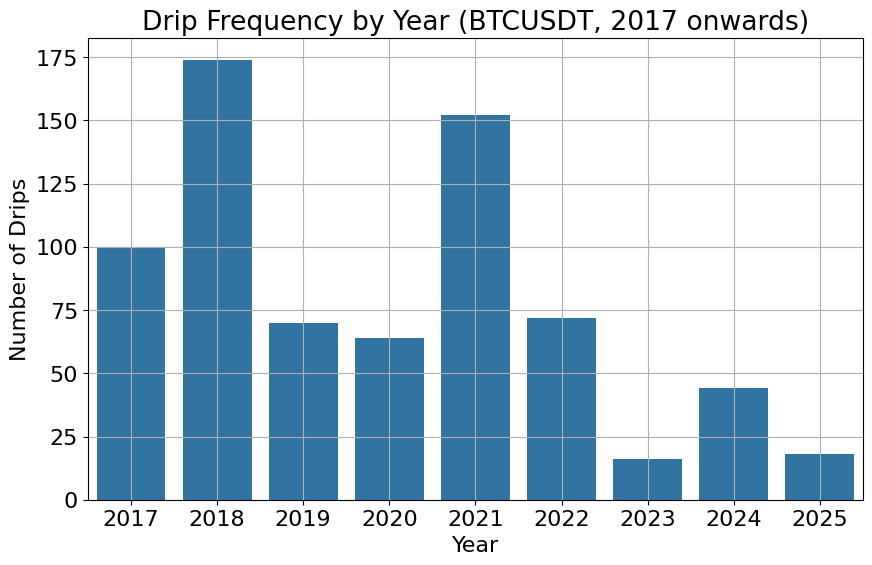

In [7]:
# สร้าง Bar Plot เพื่อแสดงความถี่
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Frequency', data=drip_frequency)
plt.title('Drip Frequency by Year (BTCUSDT, 2017 onwards)')
plt.xlabel('Year')
plt.ylabel('Number of Drips')
plt.grid(True)
plt.show()

In [8]:
# 2. Chi-Square Test: ตรวจสอบ Audible: การกระจายของความถี่ Drip ระหว่างปี
observed = drip_frequency['Frequency'].values
expected = np.full(len(observed), observed.sum() / len(observed))  # คาดหวังความถี่เท่ากันทุกปี
chi2_stat, p_value = stats.chisquare(observed, expected)
print(f"\nChi-Square Test for Drip Frequency: stat={chi2_stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Drip frequency differs significantly between years (p < 0.05)")
else:
    print("Drip frequency does not differ significantly between years (p >= 0.05)")


Chi-Square Test for Drip Frequency: stat=305.0479, p-value=0.0000
Drip frequency differs significantly between years (p < 0.05)


In [9]:
# 3. ความถี่ Drip จำแนกตามขนาด Drip
drips['drip_size_group'] = pd.cut(drips['drip_pct'], bins=[-float('inf'), -10, -5], labels=['Large (<-10%)', 'Small (-5% to -10%)'])
drip_size_frequency = drips.groupby(['year', 'drip_size_group']).size().unstack(fill_value=0).reset_index()
drip_size_frequency.columns = ['Year', 'Large (<-10%)', 'Small (-5% to -10%)']
print("\nDrip Frequency by Year and Size Group:")
print(drip_size_frequency)


Drip Frequency by Year and Size Group:
   Year  Large (<-10%)  Small (-5% to -10%)
0  2017             21                   79
1  2018             13                  161
2  2019              3                   67
3  2020              4                   60
4  2021             14                  138
5  2022              1                   71
6  2023              1                   15
7  2024              3                   41
8  2025              0                   18


/tmp/ipykernel_10240/1062776707.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drip_size_frequency = drips.groupby(['year', 'drip_size_group']).size().unstack(fill_value=0).reset_index()


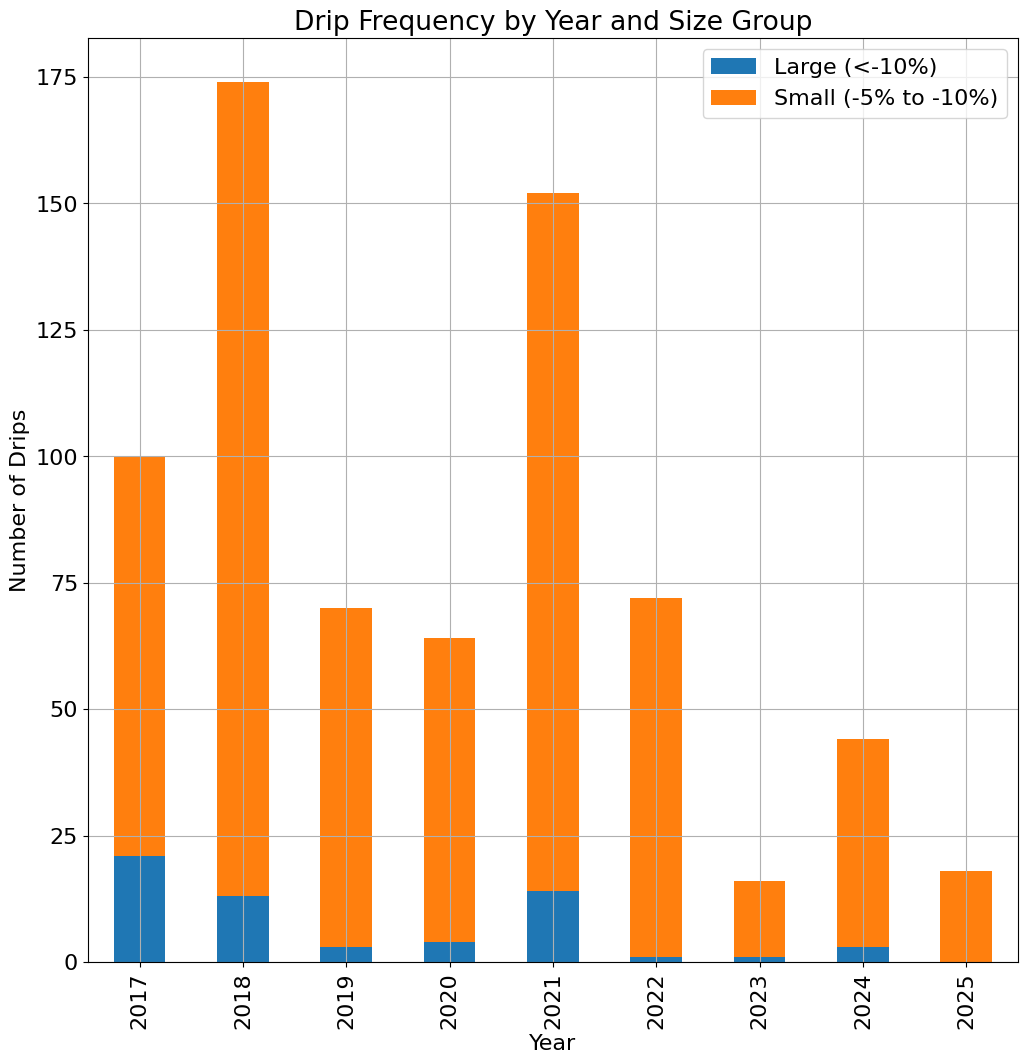

In [10]:
# สร้าง Stacked Bar Plot เพื่อแสดงความถี่ตามขนาด Drip
drip_size_frequency.set_index('Year').plot(kind='bar', stacked=True, figsize=(12, 12))
plt.title('Drip Frequency by Year and Size Group')
plt.xlabel('Year')
plt.ylabel('Number of Drips')
plt.grid(True)
plt.show()

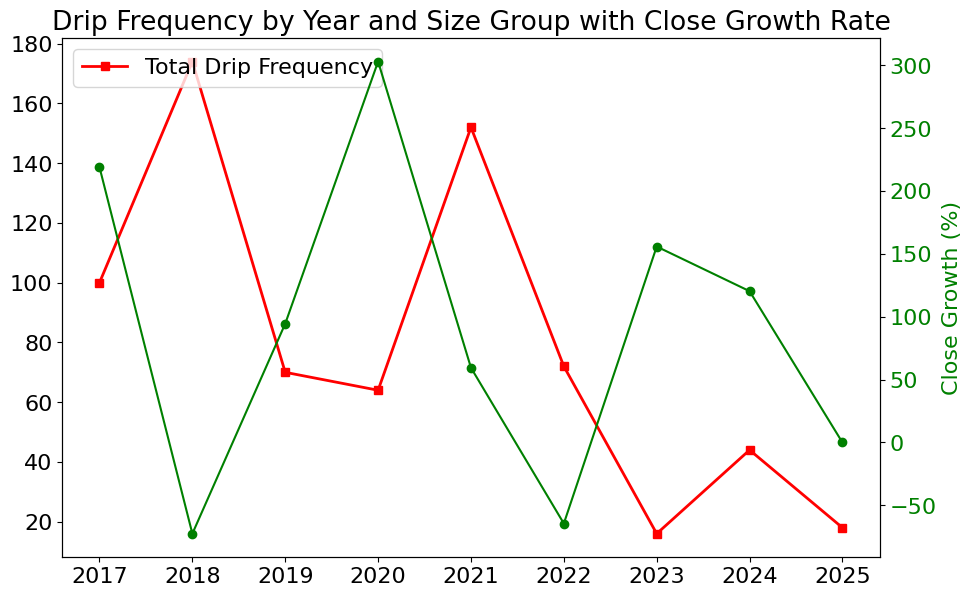

In [11]:
# คำนวณอัตราการเติบโตของ close จากต้นปีถึงปลายปี
growth_rate = []
for year in drip_size_frequency['Year']:
  year_data = data[data.index.year == year]
  if not year_data.empty:
    start_close = year_data['close'].iloc[0]
    end_close = year_data['close'].iloc[-1]
    growth = (end_close - start_close) / start_close * 100
  else:
    growth = np.nan
  growth_rate.append(growth)

# เพิ่มอัตราการเติบโตเข้าไปใน DataFrame
drip_size_frequency['Close Growth (%)'] = growth_rate

# วาดกราฟ
fig, ax1 = plt.subplots(figsize=(10, 6))

# กราฟเส้นความถี่ Drip (ใช้ drip_frequency)
ax1.plot(drip_frequency['Year'], drip_frequency['Frequency'], color='red', marker='s', label='Total Drip Frequency', linewidth=2)
ax1.legend(loc='upper left')

# กราฟเส้นอัตราการเติบโต
ax2 = ax1.twinx()
ax2.plot(drip_size_frequency['Year'], drip_size_frequency['Close Growth (%)'], color='green', marker='o', label='Close Growth (%)')
ax2.set_ylabel('Close Growth (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
# แสดงกราฟ
plt.tight_layout()
plt.title('Drip Frequency by Year and Size Group with Close Growth Rate')

plt.show()